# Examen Práctico 2
## Arantza Gomez Haro Gamboa


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import log_loss
from sklearn import discriminant_analysis
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [94]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="darkmagenta")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="lightseagreen")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

## Datos

In [3]:
df = pd.read_csv('diabetes.csv')
df = pd.get_dummies(df, columns = ['smoking_history', 'gender'])
df.head()

,age,hypertension,heart_disease,bmi,diabetes,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,gender_Female,gender_Male,gender_Other
0,80.0,0,1,25.19,0,0,0,0,0,1,0,1,0,0
1,54.0,0,0,27.32,0,1,0,0,0,0,0,1,0,0
2,28.0,0,0,27.32,0,0,0,0,0,1,0,0,1,0
3,36.0,0,0,23.45,0,0,1,0,0,0,0,1,0,0
4,76.0,1,1,20.14,0,0,1,0,0,0,0,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          100000 non-null  float64
 1   hypertension                 100000 non-null  int64  
 2   heart_disease                100000 non-null  int64  
 3   bmi                          100000 non-null  float64
 4   diabetes                     100000 non-null  int64  
 5   smoking_history_No Info      100000 non-null  uint8  
 6   smoking_history_current      100000 non-null  uint8  
 7   smoking_history_ever         100000 non-null  uint8  
 8   smoking_history_former       100000 non-null  uint8  
 9   smoking_history_never        100000 non-null  uint8  
 10  smoking_history_not current  100000 non-null  uint8  
 11  gender_Female                100000 non-null  uint8  
 12  gender_Male                  100000 non-null  uint8  
 13  

In [5]:
df.describe()

,age,hypertension,heart_disease,bmi,diabetes,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,gender_Female,gender_Male,gender_Other
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,0.085000,0.358160,0.092860,0.040040,0.093520,0.35095,0.06447,0.585520,0.414300,0.000180
std,22.516840,0.26315,0.194593,6.636783,0.278883,0.479462,0.290238,0.196054,0.291161,0.47727,0.24559,0.492635,0.492603,0.013415
min,0.080000,0.00000,0.000000,10.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.00000,1.000000,1.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000


In [6]:
target = 'diabetes'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)
X.head()

,age,hypertension,heart_disease,bmi,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,gender_Female,gender_Male,gender_Other
0,80.0,0,1,25.19,0,0,0,0,1,0,1,0,0
1,54.0,0,0,27.32,1,0,0,0,0,0,1,0,0
2,28.0,0,0,27.32,0,0,0,0,1,0,0,1,0
3,36.0,0,0,23.45,0,1,0,0,0,0,1,0,0
4,76.0,1,1,20.14,0,1,0,0,0,0,0,1,0


In [7]:
numerical_features = ['age', 'bmi']

## Modelos sin modificaciones

### KNN Clasificador

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': np.arange(1, 30), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

In [10]:
random_search_knn= RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=15, cv = 5, n_jobs=-1, scoring='roc_auc')
random_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [11]:
random_knn = random_search_knn.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_score=random_knn, y_true=y_test)

0.7994029076070673

### Regresión Logística

In [12]:
pipeline = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ])

params_grid= {
    'poly__degree':[1,2,3],
    'logreg__penalty':[ 'l2', None],
    'logreg__C':[0.01, 0.1, 1]}

In [13]:
random_search_log = RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=15, cv = 5, n_jobs=-1, scoring='roc_auc')
random_search_log.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [14]:
random_search_log.best_params_

{'poly__degree': 2, 'logreg__penalty': 'l2', 'logreg__C': 1}

In [15]:
random_log = random_search_log.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_score=random_log, y_true=y_test)

0.8385362120654222

In [16]:
feature_names = random_search_log.best_estimator_.named_steps['poly'].get_feature_names_out(X_train.columns)
coeficientes = random_search_log.best_estimator_.named_steps['logreg'].coef_[0]
coeficientes = pd.DataFrame({'variable': feature_names, 'coeficiente': coeficientes})
coeficientes = coeficientes.sort_values(by='coeficiente', ascending=False)
coeficientes

,variable,coeficiente
0,age,0.926197
16,age bmi,0.582225
3,bmi,0.581331
23,age gender_Female,0.425818
21,age smoking_history_never,0.392630
...,...,...
28,hypertension bmi,-0.175054
14,age hypertension,-0.329007
49,bmi^2,-0.331241
15,age heart_disease,-0.367628


### Discriminante lineal

In [17]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

In [18]:
pipeline.fit(X_train, y_train)
probabilidad_dl = pipeline.predict_proba(X_test)[:, 1]

In [19]:
roc_auc_score(y_score=probabilidad_dl, y_true= y_test)

0.8279248494754109

### Red Neuronal

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier())
])

params_grid = {
    'nn__hidden_layer_sizes': [(100,50,100), (10,), (100,), (10,10)],
    'nn__activation': ['tanh', 'relu', 'logistic'],
    'nn__alpha': [0.1, 0.01, 0.001]}

In [21]:
random_search_rn = RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=15, cv = 5, n_jobs=-1, scoring='roc_auc')
random_search_rn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn', MLPClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01, 0.001],
                                        'nn__hidden_layer_sizes': [(100, 50,
                                                                    100),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [22]:
random_search_rn.best_params_

{'nn__hidden_layer_sizes': (10, 10),
 'nn__alpha': 0.01,
 'nn__activation': 'tanh'}

In [23]:
random_rn = random_search_rn.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_score=random_rn, y_true=y_test)

0.8373774467127334

## Gráficas de calibración (sin modificaciones)

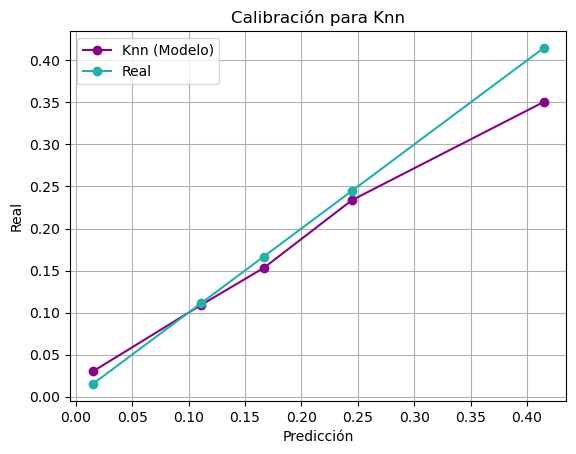

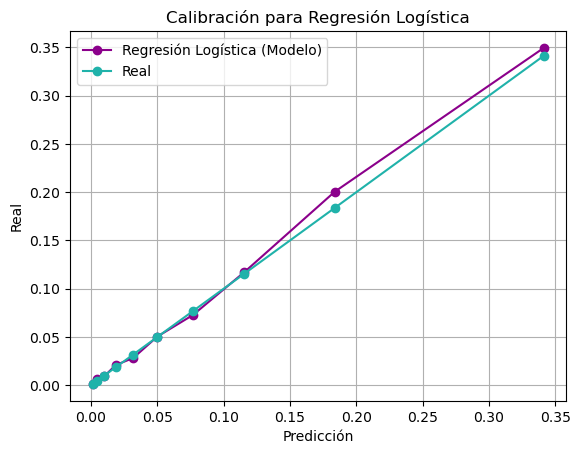

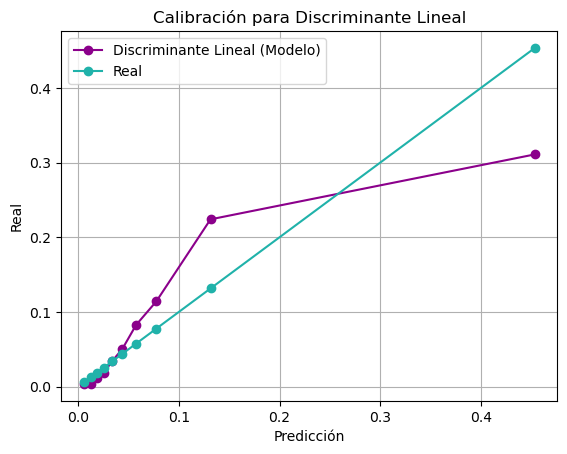

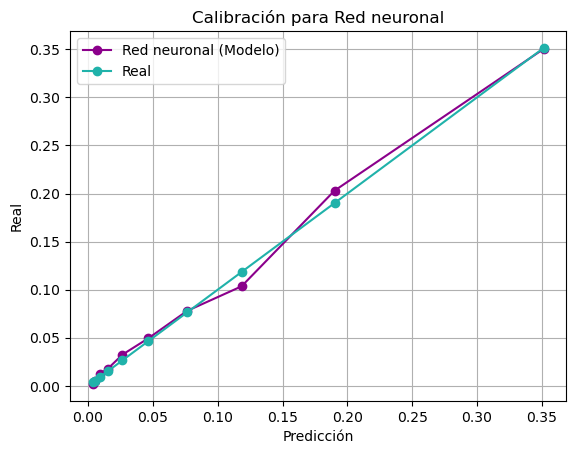

In [95]:
modelos = {
    'Knn': random_knn,
    'Regresión Logística': random_log,
    'Discriminante Lineal': probabilidad_dl,
    'Red neuronal': random_rn,
}

calibracion_multiple(modelos, y_test, bins=10)

## Histogramas (sin modificaciones)

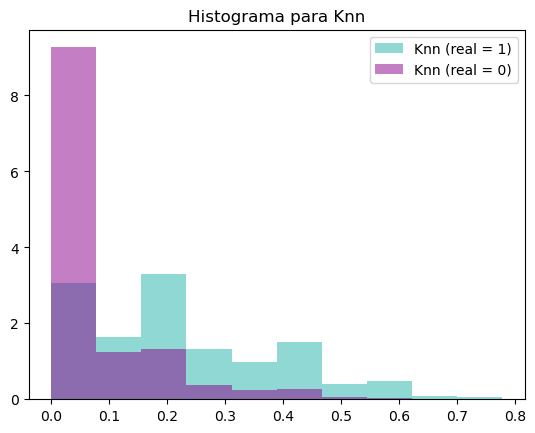

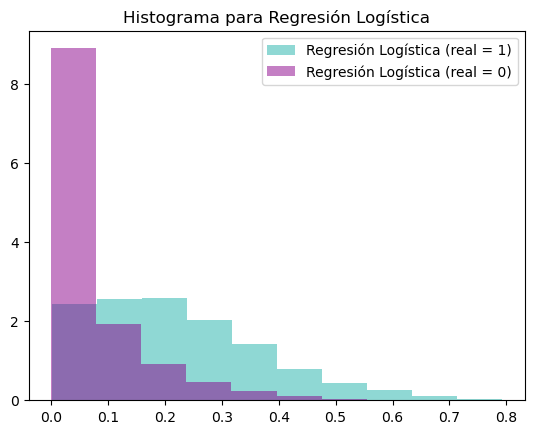

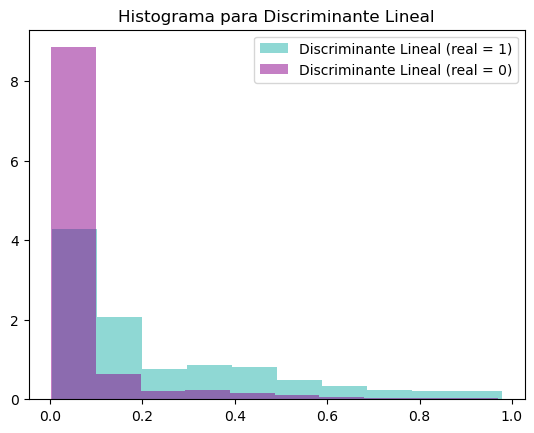

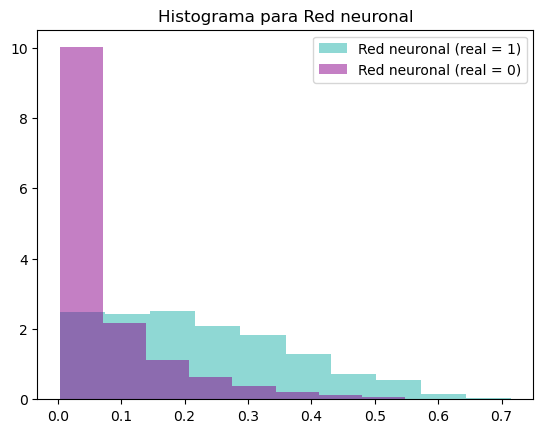

In [25]:
histogramas = pd.DataFrame({
    'real': y_test,
    'Knn': random_knn,
    'Regresión Logística': random_log,
    'Discriminante Lineal': probabilidad_dl,
    'Red neuronal': random_rn,
})

real1 = histogramas[histogramas['real'] == 1]
real0 = histogramas[histogramas['real'] == 0]

modelos = ['Knn', 'Regresión Logística', 'Discriminante Lineal', 'Red neuronal']

for modelo in modelos:
    plt.hist(real1[modelo], density=True, alpha=0.5, bins=10, color='lightseagreen', label=f'{modelo} (real = 1)')
    plt.hist(real0[modelo], density=True, alpha=0.5, bins=10, color='darkmagenta', label=f'{modelo} (real = 0)')
    plt.title(f'Histograma para {modelo}')
    plt.legend()
    plt.show()

## Curvas ROC (sin modificaciones)

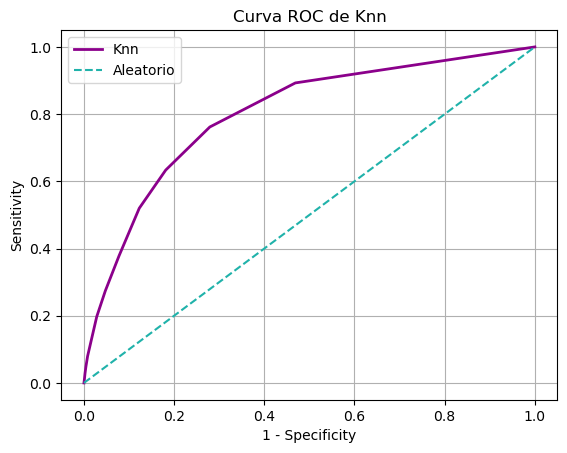

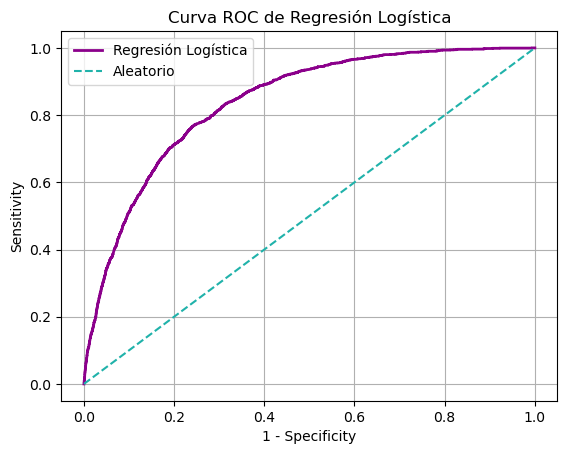

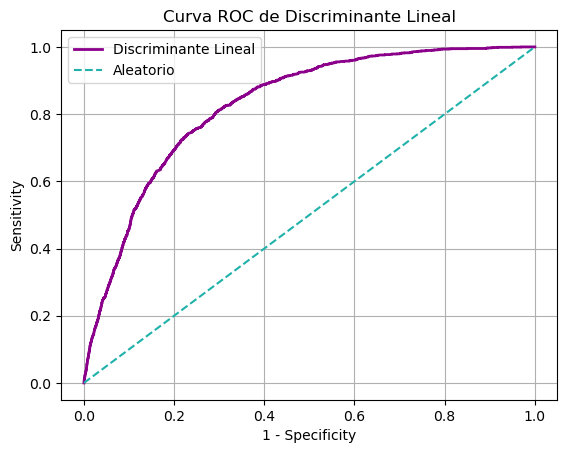

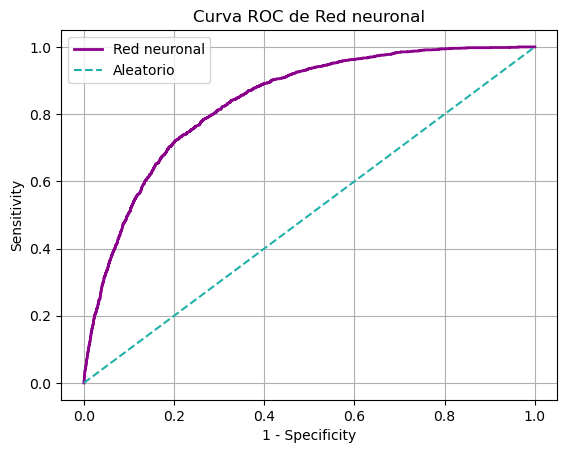

In [77]:
modelos = ['Knn', 'Regresión Logística', 'Discriminante Lineal', 'Red neuronal']
resultados = [random_knn, random_log, probabilidad_dl, random_rn]

for i, modelo in enumerate(modelos):
    predicciones = resultados[i]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predicciones) 
    plt.plot(fpr, tpr, label=f'{modelo}', color='darkmagenta', lw=2)
    plt.plot([0, 1], [0, 1], color='lightseagreen', linestyle='--', lw=1.5, label='Aleatorio')
    plt.title(f'Curva ROC de {modelo}')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.grid(True)
    plt.show()

## Todos los AUC (sin modificaciones)

In [59]:
tabla = pd.DataFrame({
    'KNN': roc_auc_score(y_score=random_knn, y_true= y_test),
    'Regresión logística': roc_auc_score(y_score=random_log, y_true= y_test),
    'Discriminante lineal': roc_auc_score(y_score=probabilidad_dl, y_true= y_test),
    'Red neuronal': roc_auc_score(y_score=random_rn, y_true= y_test)
},index=['AUC'])
tabla

,KNN,Regresión logística,Discriminante lineal,Red neuronal
AUC,0.799403,0.838536,0.827925,0.837377


### Análisis

- Al realizar todos los modelos, se llega a la conclusión que el modelo con mayor AUC fue el de **regresión logística de grado 2** con un AUC de 0.8385. Este número nos indica que el modelo tiene una buena capacidad para classificar entre las clases. Es decir, existe un 83.85% de probabilidad de que la probabilidad de predecir alguien con diabetes sea mayor a que se prediga alguien sin diabetes. Esta mayor precisión se puede apreciar en la gráfica de calibración, donde el modelo hace un buen trabajo al ajustarse a los datos reales. Por otro lado, en cuestión de los coeficientes, los que obtuvieron un valor mayor fueron **age**, **age bmi** y **bmi**. Estos coeficientes nos indican como cambian los log odds por cada aumento unitario de cada uno de los features. Las tres variables mencionadas cuentan con un coeficiente mayor a 0.57, indicando un cambio fuerte y positivo en los log odds. Por último, tomando en cuenta los histogramas de cada modelo, se puede apreciar, en todos los modelos, una concentración a la izquierda de la clase 0, mientras que la clase 1 esta más dispera en las distintas probabilidades.  

## Análisis Bivariado

C:\Users\arant\AppData\Local\Temp\ipykernel_20632\1280963741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_df['bins'] = pd.qcut(flag_df[i], q=10, labels=False, duplicates = "drop") + 1


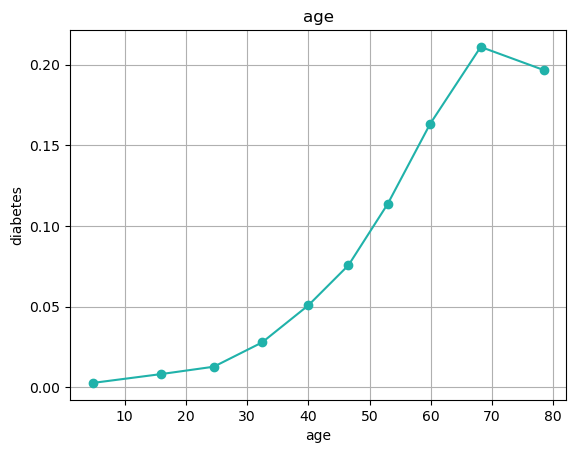

C:\Users\arant\AppData\Local\Temp\ipykernel_20632\1280963741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_df['bins'] = pd.qcut(flag_df[i], q=10, labels=False, duplicates = "drop") + 1


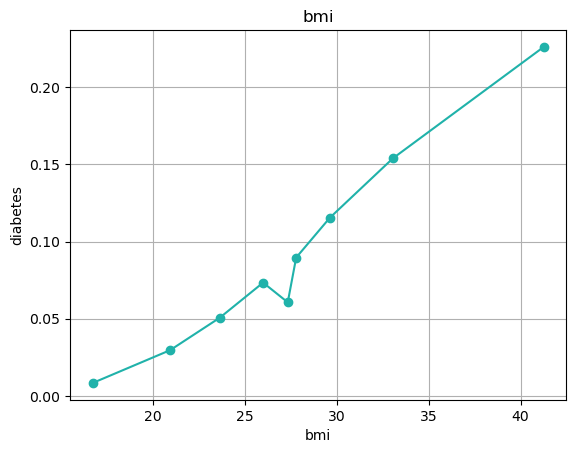

In [28]:
for i in numerical_features:
    if i != 'diabetes':
        flag_df = df[[target, i]]
        flag_df['bins'] = pd.qcut(flag_df[i], q=10, labels=False, duplicates = "drop") + 1
        grouped = flag_df.groupby('bins').mean()
        plt.figure()
        plt.plot(grouped[i], grouped[target], marker="o", color = "lightseagreen")
        plt.grid()
        plt.xlabel(i)
        plt.ylabel(target)
        plt.title(i)
        plt.show()

## Feature Engineering

In [29]:
df['log_age'] = np.log(df['age'] + 1)
df['log_bmi'] = np.log(df['bmi'] + 1)
df['age_bmi'] = df['log_bmi']*df['log_age']
df['age_entre_bmi'] = df['log_age']/df['log_bmi']

In [30]:
X_otro = df.copy()
X_otro = X_otro.drop(target, axis = 1)
X_otro.head()

,age,hypertension,heart_disease,bmi,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,gender_Female,gender_Male,gender_Other,log_age,log_bmi,age_bmi,age_entre_bmi
0,80.0,0,1,25.19,0,0,0,0,1,0,1,0,0,4.394449,3.265378,14.349536,1.345771
1,54.0,0,0,27.32,1,0,0,0,0,0,1,0,0,4.007333,3.343568,13.398792,1.198520
2,28.0,0,0,27.32,0,0,0,0,1,0,0,1,0,3.367296,3.343568,11.258783,1.007096
3,36.0,0,0,23.45,0,1,0,0,0,0,1,0,0,3.610918,3.196630,11.542769,1.129601
4,76.0,1,1,20.14,0,1,0,0,0,0,0,1,0,4.343805,3.051167,13.253676,1.423654


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_otro, y, test_size=0.2, random_state=42)

## Modelos con modificaciones

### KNN Clasificador

In [32]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': np.arange(1,30), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

In [33]:
random_search_knn_nuevo = RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=15, cv=5, n_jobs =-1, scoring='roc_auc')
random_search_knn_nuevo.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [34]:
random_knn_nuevo = random_search_knn_nuevo.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_score=random_knn_nuevo, y_true=y_test)

0.810134218078724

### Regresión Logística

In [35]:
pipeline = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ])

params_grid= {
    'poly__degree':[1,2,3],
    'logreg__penalty':[ 'l2', None],
    'logreg__C':[0.01, 0.1, 1]}

In [36]:
random_search_log_nuevo = RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=15, cv = 5, n_jobs=-1, scoring='roc_auc')
random_search_log_nuevo.fit(X_train, y_train)

C:\Users\arant\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
13 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\arant\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\arant\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arant\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, route

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [37]:
random_search_log_nuevo.best_params_

{'poly__degree': 2, 'logreg__penalty': 'l2', 'logreg__C': 1}

In [38]:
random_log_nuevo = random_search_log_nuevo.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_score=random_log_nuevo, y_true=y_test)

0.8386387318959518

In [96]:
feature_names = random_search_log_nuevo.best_estimator_.named_steps['poly'].get_feature_names_out(X_train.columns)
coeficientes = random_search_log_nuevo.best_estimator_.named_steps['logreg'].coef_[0]
coeficientes = pd.DataFrame({'variable': feature_names, 'coeficiente': coeficientes})
coeficientes = coeficientes.sort_values(by='coeficiente', ascending=False)
coeficientes

,variable,coeficiente
33,age age_entre_bmi,1.071068
77,bmi age_bmi,0.782077
75,bmi log_age,0.767860
25,age smoking_history_never,0.647762
3,bmi,0.642075
...,...,...
130,smoking_history_never log_age,-0.536831
132,smoking_history_never age_bmi,-0.589827
14,log_bmi,-0.820777
65,bmi^2,-1.343829


### Discriminante Lineal

In [40]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

In [41]:
pipeline.fit(X_train, y_train)
probabilidad_dl_nuevo = pipeline.predict_proba(X_test)[:, 1]

In [42]:
roc_auc_score(y_score=probabilidad_dl_nuevo, y_true= y_test)

0.8309115597302362

### Red neuronal

In [43]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier())
])

params_grid = {
    'nn__hidden_layer_sizes': [(100,50,100), (10,), (100,), (10,10)],
    'nn__activation': ['tanh', 'relu', 'logistic'],
    'nn__alpha': [0.1, 0.01, 0.001]}

In [45]:
random_search_rn_nuevo = RandomizedSearchCV(estimator=pipeline, param_distributions=params_grid, n_iter=15, cv = 5, n_jobs=-1, scoring='roc_auc')
random_search_rn_nuevo.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn', MLPClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01, 0.001],
                                        'nn__hidden_layer_sizes': [(100, 50,
                                                                    100),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [46]:
random_search_rn_nuevo.best_params_

{'nn__hidden_layer_sizes': (10,),
 'nn__alpha': 0.001,
 'nn__activation': 'logistic'}

In [47]:
random_rn_nuevo = random_search_rn_nuevo.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_score=random_rn_nuevo, y_true=y_test)

0.8378997761271612

## Gráficas de calibración (con modificaciones)

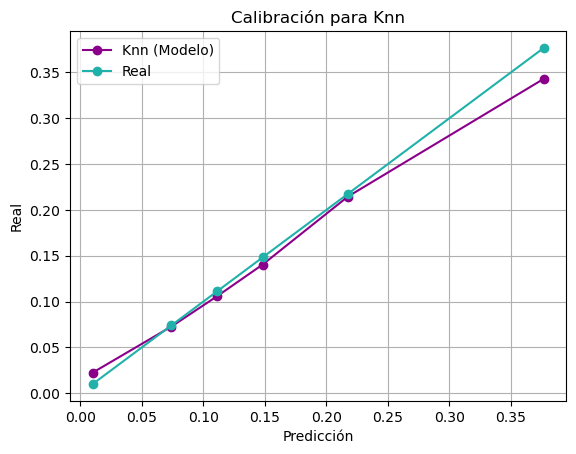

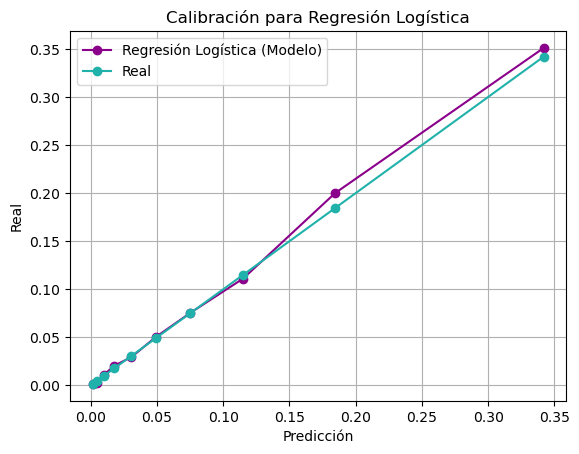

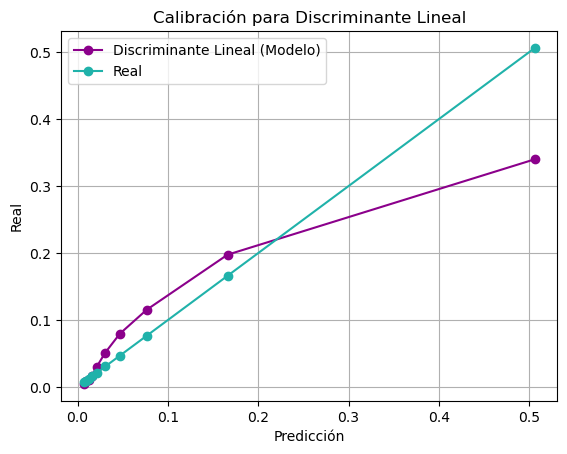

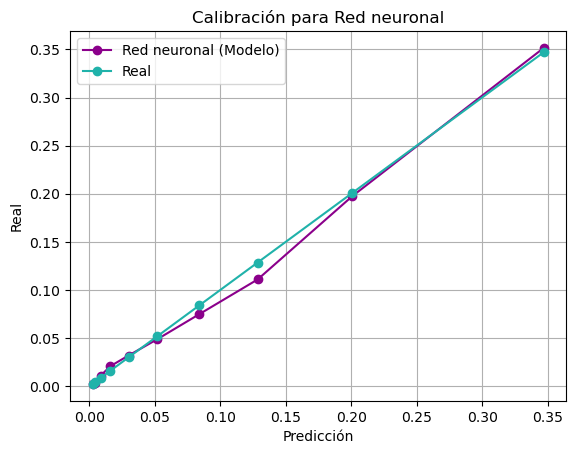

In [49]:
modelos = {
    'Knn': random_knn_nuevo,
    'Regresión Logística': random_log_nuevo,
    'Discriminante Lineal': probabilidad_dl_nuevo,
    'Red neuronal': random_rn_nuevo,
}


calibracion_multiple(modelos, y_test, bins=10)

## Histogramas (con modificaciones)

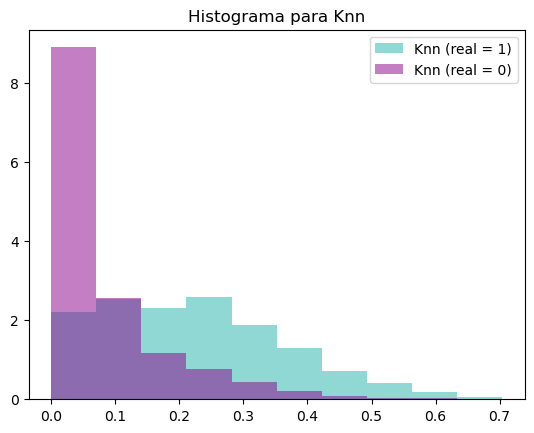

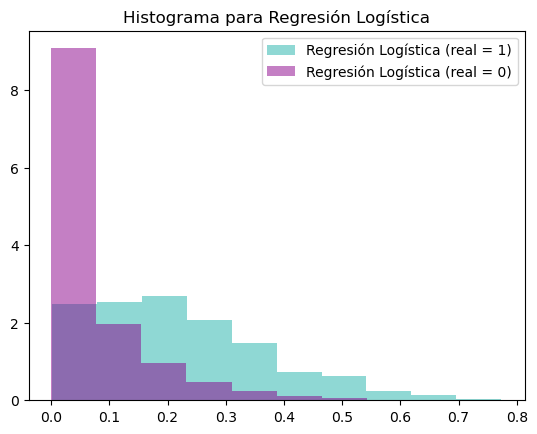

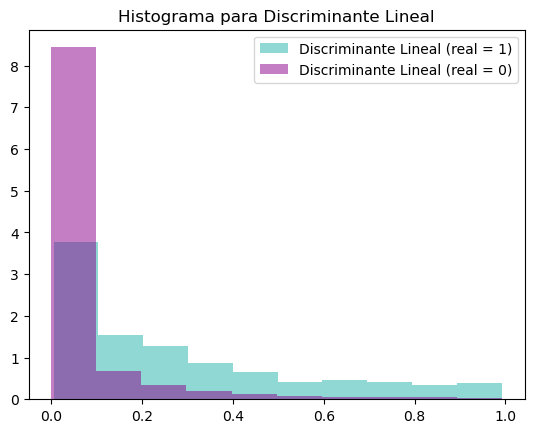

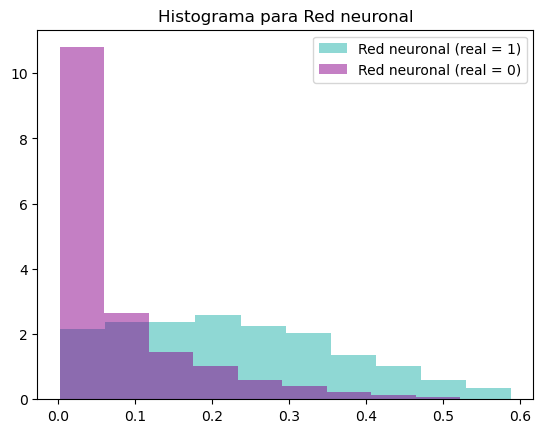

In [70]:
histogramas = pd.DataFrame({
    'real': y_test,
    'Knn': random_knn_nuevo,
    'Regresión Logística': random_log_nuevo,
    'Discriminante Lineal': probabilidad_dl_nuevo,
    'Red neuronal': random_rn_nuevo,
})

real1 = histogramas[histogramas['real'] == 1]
real0 = histogramas[histogramas['real'] == 0]

modelos = ['Knn', 'Regresión Logística', 'Discriminante Lineal', 'Red neuronal']

for modelo in modelos:
    plt.hist(real1[modelo], density=True, alpha=0.5, bins=10, color='lightseagreen', label=f'{modelo} (real = 1)')
    plt.hist(real0[modelo], density=True, alpha=0.5, bins=10, color='darkmagenta', label=f'{modelo} (real = 0)')
    plt.title(f'Histograma para {modelo}')
    plt.legend()
    plt.show()

## Curvas ROC (con modificaciones)

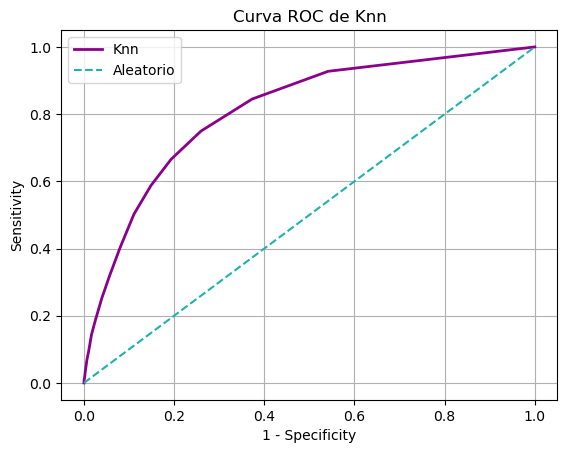

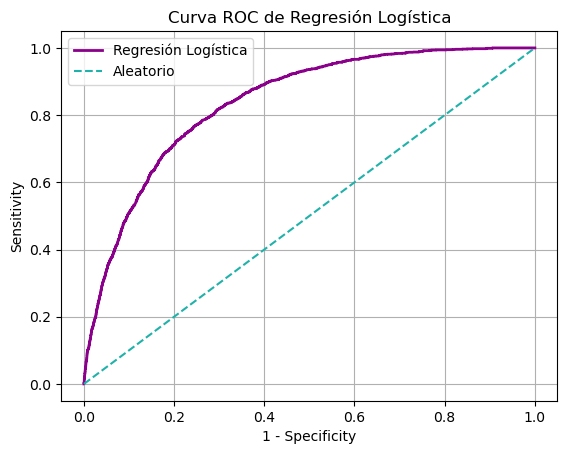

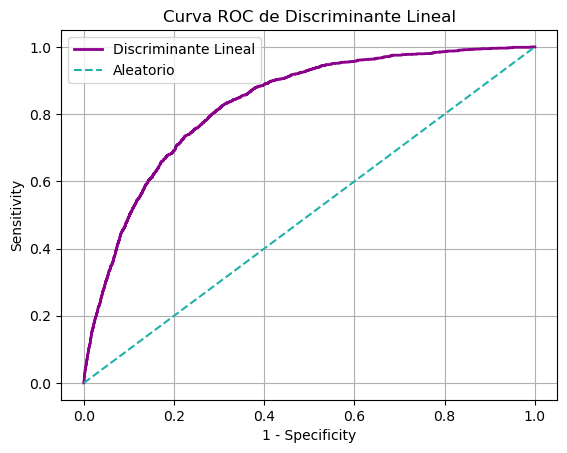

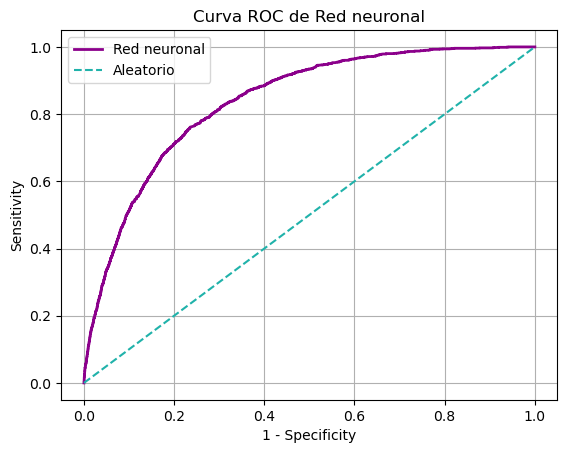

In [76]:
modelos = ['Knn', 'Regresión Logística', 'Discriminante Lineal', 'Red neuronal']
resultados = [random_knn_nuevo, random_log_nuevo, probabilidad_dl_nuevo, random_rn_nuevo]

for i, modelo in enumerate(modelos):
    predicciones = resultados[i]
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=predicciones) 
    plt.plot(fpr, tpr, label=f'{modelo}', color='darkmagenta', lw=2)
    plt.plot([0, 1], [0, 1], color='lightseagreen', linestyle='--', lw=1.5, label='Aleatorio')
    plt.title(f'Curva ROC de {modelo}')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.grid(True)
    plt.show()

## Todos los AUC (con modificaciones)

In [57]:
tabla2 = pd.DataFrame({
    'KNN': roc_auc_score(y_score=random_knn_nuevo, y_true= y_test),
    'Regresión logística': roc_auc_score(y_score=random_log_nuevo, y_true= y_test),
    'Discriminante lineal': roc_auc_score(y_score=probabilidad_dl_nuevo, y_true= y_test),
    'Red neuronal': roc_auc_score(y_score=random_rn_nuevo, y_true= y_test)
},index=['AUC'])
tabla2

,KNN,Regresión logística,Discriminante lineal,Red neuronal
AUC,0.810134,0.838639,0.830912,0.8379


## Todos los AUC (sin modificaciones)

In [60]:
tabla

,KNN,Regresión logística,Discriminante lineal,Red neuronal
AUC,0.799403,0.838536,0.827925,0.837377


### Análisis

- Con las dos tablas anteriores, que muestran los AUC de cada modelo con y sin feature engineering, se puede ver claramente una mejora en cada uno de los modelos al realizar las modificaciones, aunque sea una mejora mínima. Cabe mencionar, se realizaron dos transformaciones, que fueron el logarítmo de ambas variables numéricas (age y bmi), y se agregaron dos variables nuevas que fueron la multiplicación y división de estas transformaciones. Dicho esto, el modelo con mayor valor de AUC fue el de **regresión logística grado 2**, con un AUC de 0.8386. Esto nos indica que el modelo tiene una buena capacidad de clasificar entre clases. Además, existe un 83.86% de probabilidad de que la probabilidad de predecir alguien con diabetes sea mayor a que se prediga alguien sin diabetes. Esta precisión es evidente en la gráfica de calibración, donde se puede ver que el modelo se ajusta de buena manera a los datos reales. Por otro lado, los features con los coeficientes más altps fueron los de **age_entre_bmi**, **bmi age_bmi** y **bmi log_age**. Como podemos ver, ests tres features se agregaron con el feature engineering, y tienen un impacto positivo y fuerte en los log odds. Con esto podemos concluir que el feature engineering si ayudó a incrementar el AUC de los modelos, aunque fuera un cambio pequeño. Por último, en cuestión de los histogramas, los cuales nos muestran la distribución de las predicciones de cada modelo, podemos ver como la clase 1 se encuentra con mayor distribución a través de las probabilidades, mientras que la clase 0 se encuntra mayormente concentrada a la izquierda de las graficas. Esto es igual que antes de hacer las modificaciones, simplemente con pequeños cambios. 


- Como conclusión general, con este trabajo podemos ver la importancia de utilizar diferentes modelos para realmente obtener la mayor precisión posible. Además, el realizar transformaciones y modificaciones es una gran manera de ajustar de mejor manera los modelos a los datos. Cabe mencionar que, en este caso no se pude utilizar Grid Search dado la alta cantidad de información que se tenía que procesar, sin embargo, podría ser una buena manera de mejorar aún más el AUC de cada modelo, ya que se utilizan todas las combinaciones posibles. 